In [1]:
%reset -f
%config Completer.use_jedi = True
# %matplotlib widget

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os,glob,sys,importlib#,scipy,coolbox,pybedtools,
from scipy.stats import linregress
from scipy.ndimage import gaussian_filter
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from scipy import stats
import biosppy
# from sklearn import metrics
os.chdir('/home/dcmorgan')
os.getcwd()

# sys.path.insert(1, './run/oric/Plectoneme/')
# import savitzky_golay
# importlib.reload(sys.modules['savitzky_golay'])
# from savitzky_golay import savitzky_golay

# import networkx as nx
# from joblib.externals.loky import set_loky_pickler
# from joblib import parallel_backend
# from joblib import Parallel, delayed
# from joblib import wrap_non_picklable_objects


'/home/dcmorgan'

In [ ]:
!cut -f2,3,4 ~/data/meta/NC_004252_R0396-MWT.bedgraph

## Raw Gut x pheno

In [ ]:
primary=pd.read_excel('data/Data Raw - Gut Microbiome Cohort Project Database - 300 Cohort v3.0_280921.xlsx',index_col=0,sheet_name='Primary Data')
diet=pd.read_excel('data/Data Raw - Gut Microbiome Cohort Project Database - 300 Cohort v3.0_280921.xlsx',index_col=0,sheet_name='Diet Data')
blood_stool=pd.read_excel('data/Data Raw - Gut Microbiome Cohort Project Database - 300 Cohort v3.0_280921.xlsx',index_col=0,sheet_name='blood and stool biomarkers')
secondary=pd.read_excel('data/Data Raw - Gut Microbiome Cohort Project Database - 300 Cohort v3.0_280921.xlsx',index_col=0,sheet_name='Secondary Data')
MRI=pd.read_excel('data/Data Raw - Gut Microbiome Cohort Project Database - 300 Cohort v3.0_280921.xlsx',index_col=0,sheet_name='MRI scores')

In [ ]:
unibact=pd.read_csv('data/328_krakenuniq_raw.csv',index_col=0)
unibact['spec']=(unibact.index).str.split(';').str[0:6].tolist()
# jeff=pd.DataFrame(unibact['spec'].tolist(),columns=['tmp','tmp','tmp','tmp','tmp','species'])
# jeff=jeff.fillna(method='ffill',axis=1)


In [ ]:
unibact.columns=unibact.columns.str.split('-').str[0].tolist()

In [ ]:
PP=primary[primary.index.isin(unibact.columns)]



In [ ]:
sub_uni=unibact[primary.index[primary.index.isin(unibact.columns)]]
sub_uni.columns=PP['Hypertension Category by 24h BP w/o considering antihypertensive med']
# sub_uni

### corr network

In [ ]:
aa=np.corrcoef((sub_uni[2]).astype(float))
# aa=aa[aa!=1]
a=plt.hist(aa.flatten(),bins=100,log=True,alpha=.65)

bb=np.corrcoef((sub_uni[1]).astype(float))
# bb=bb[bb!=1]
b=plt.hist(bb.flatten(),bins=100,log=True,alpha=.5)

cc=np.corrcoef((sub_uni[0]).astype(float))
# cc=cc[cc!=1]
c=plt.hist(cc.flatten(),bins=100,log=True,alpha=.35)

In [ ]:
a=nx.from_numpy_array(aa[1:100,1:100])
b=nx.from_numpy_array(bb[1:100,1:100])
c=nx.from_numpy_array(cc[1:100,1:100])

# cc.shape

In [ ]:
nx.draw(a)
nx.draw(b)
nx.draw(c)

In [ ]:
# nx.from_numpy_array(aa[(aa>.5)&(aa[1:100,1:100])])
nx.average_clustering(a)

In [ ]:
aa=np.array(stats.spearmanr(sub_uni[2],axis=1))
# aa=aa[aa!=1]
a=plt.hist(aa.flatten(),bins=100,log=True,alpha=.65)

bb=np.array(stats.spearmanr(sub_uni[1],axis=1))
# bb=bb[bb!=1]
b=plt.hist(bb.flatten(),bins=100,log=True,alpha=.5)

cc=np.array(stats.spearmanr(sub_uni[0],axis=1))
# cc=cc[cc!=1]
c=plt.hist(cc.flatten(),bins=100,log=True,alpha=.35)

In [ ]:
ww=plt.hist(bb-cc,bins=100,alpha=.65,log=True)
ww=plt.hist(bb-aa,bins=100,alpha=.5,log=True)
ww=plt.hist(aa-cc,bins=100,alpha=.35,log=True)

In [ ]:
from scipy import stats
cc=np.array(stats.spearmanr(unibact.values[0:1000,0:1000])).flatten()
cc=cc[cc!=1]
# np.array(cc)
cc=plt.hist(cc,bins=100,log=True)

## OriC data

In [ ]:
oric=pd.read_csv('data/doric10/tubic_bacteria.csv') #remove 'note' and 'nt*' from file

In [ ]:
oric['oric_start']=oric['Location of replication origin'].str.split('.').str[0].str.split(',').str[0].str.split(';').str[0].tolist()
oric['oric_end']=oric['Location of replication origin'].str.split('.').str[2].str.split(',').str[0].str.split(';').str[0].tolist()
oric['gene_start']=oric['Location of replication genes'].str.split('.').str[0].str.split(',').str[0].str.split(';').str[0].tolist()
oric['gene_end']=oric['Location of replication genes'].str.split('.').str[2].str.split(',').str[0].str.split(';').str[0].tolist()

In [ ]:
oric['OriC AT content']=np.round(oric['OriC AT content']*100).astype(int)
oric['orgA']=oric['Organism'].str.split(' ').str[0].tolist()
oric['orgB']=oric['Organism'].str.split(' ').str[1].tolist()
oric['Organism']=oric['orgA']+'_'+oric['orgB']


In [ ]:
oric[['oric_start','oric_end','gene_start','gene_end']]=oric[['oric_start','oric_end','gene_start','gene_end']].replace('-','1')
oric=oric.fillna('1')

In [ ]:
oric[['gene_start']]=oric[['gene_start']].astype(int)
oric[['gene_end']]=oric[['gene_end']].astype(int)
oric[['oric_start']]=oric[['oric_start']].astype(int)
oric[['oric_end']]=oric[['oric_end']].astype(int)

In [ ]:
# oric['end']=np.amax(oric[['oric_start','oric_end','gene_start','gene_end']],1)
# oric['start']=np.amin(oric[['oric_start','oric_end','gene_start','gene_end']],1)
jj=ori[ori['oric_start']>ori['oric_end']]#
jj['oric_end']=jj['oric_start']+jj['oric_end']
ff=ori[ori['oric_start']<ori['oric_end']]
ORIC=ff.append(jj)

In [ ]:
ORIC['refseq']=ORIC['Refseq'].str.split('.').str[0].tolist()
ORIC['len']=ORIC['oric_end']-ORIC['oric_start']

In [ ]:
ORIC[['refseq','oric_start','oric_end','OriC AT content','Organism','len']].to_csv('data/doric10/OriC_db.bed',sep='\t',header=True,index=False)

In [ ]:
sns.set_style("white")
tmp=plt.hist(ORIC['len'],bins=100,log=True)

## circular plots

In [ ]:
zzz=pd.read_csv(jac,sep='\t',names=['tmp','start','end','relAb'])
tmp=ori[ori['Refseq'].str.contains('NC_'+jac.split('/')[2].split('_')[1])]
plt.figure(figsize=(20, 5))

plt.bar(data=zzz[(zzz['start']>3000000)&(zzz['end']<3500000)],x='start',height='relAb',label='align',color='blue')#][zzz['start']=='1665929']
plt.bar(data=tmp,x='start',height='OriC AT content',label='OriC start',color='orange')
plt.bar(data=tmp,x='end',height='OriC AT content',label='OriC end',color='orange')

plt.axes([.2, .6, .6, .2])
plt.bar(data=zzz[(zzz['start']>np.int(np.round(tmp['start'].item(),-1))-100) &(zzz['end']<np.int(np.round(tmp['end'].item(),-1))+100)],x='start',height='relAb',label='align',color='blue')#][zzz['start']=='1665929']
plt.bar(data=tmp,x='start',height='OriC AT content',label='OriC start',color='orange')
plt.bar(data=tmp,x='end',height='OriC AT content',label='OriC end',color='orange')


plt.xlabel("OriC ranges from "+str(tmp['start'].item())+" to "+str(tmp['end'].item())+" for "
        +str(tmp['Organism'].item())+" in "+str(os.path.basename(jac).split('_')[2].split('.')[0])+
           "max= "+np.max(zzz['relAb'])+" at "+str(zzz[zzz['relAb']==np.max(zzz['relAb'])][['start']].index.values)+"; median= "+np.median(zzz['relAb']),fontsize=14)
 

In [ ]:
# traces[1]
tmp

In [ ]:
traces= glob.glob('data/meta_unfilt/*bedgraph')
ori=pd.read_csv('data/doric10/OriC_db.bed',sep='\t')

# for jac in traces:
jac=traces[1]
zzz=pd.read_csv(jac,sep='\t',names=['tmp','start','end','relAb'])
tmp=ori[ori['Refseq'].str.contains('NC_'+jac.split('/')[2].split('_')[1])]

aa=zzz[['start','relAb']]
aa.rename(columns={"start":"Name","relAb":"Value"},inplace=True)
df0=aa.groupby(aa.index // 2000).sum()
df=(df0)
df=df0
df['Name']=np.round(df['Name'],3)
df=df.sort_values(by=['Name'])
# df=df0
# del df['Value']
# df=df.rename(columns={'logValue':"Value"})

In [ ]:
# set figure size
plt.figure(figsize=(20,10))

# plot polar axis
ax = plt.subplot(111, polar=True)

# remove grid
plt.axis('off')

# Set the coordinates limits
upperLimit = 100#np.max(df.Value)
lowerLimit = 10#np.min(df.Value)

# Compute max and min in the dataset
max = df['Value'].max()

# Let's compute heights: they are a conversion of each item value in those new coordinates
# In our example, 0 in the dataset will be converted to the lowerLimit (10)
# The maximum will be converted to the upperLimit (100)
slope = (max - lowerLimit) / max
heights = slope * df.Value + lowerLimit

# Compute the width of each bar. In total we have 2*Pi = 360°
width = 2*np.pi / len(df.index)

# Compute the angle each bar is centered on:
indexes = list(range(1, len(df.index)+1))
angles = [element * width for element in indexes]
angles

# Draw bars
bars = ax.bar(
    x=angles, 
    height=heights, 
    width=width, 
    bottom=lowerLimit,
    linewidth=2, 
    edgecolor="white")


# little space between the bar and the label
labelPadding = 4

# Add labels
for bar, angle, height, label in zip(bars,angles, heights, df["Name"]):

    # Labels are rotated. Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle)

    # Flip some labels upside down
    alignment = ""
    if angle >= np.pi/2 and angle < 3*np.pi/2:
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"

    # Finally add the labels
    ax.text(
        x=angle, 
        y=lowerLimit + bar.get_height() + labelPadding, 
        s=label, 
        ha=alignment, 
        va='center', 
        rotation=rotation, 
        rotation_mode="anchor") 

## circular plot 2

[adapted from tutorial](https://www.python-graph-gallery.com/web-circular-lollipop-plot-with-matplotlib)

[checkout GCskew wiki](https://en.wikipedia.org/wiki/GC_skew)

In [ ]:
import random
# The plot consists of 2 rows and 5 columns (10 categories in total)
fig, axes = plt.subplots(10, 3, figsize=(40, 40), subplot_kw={"projection": "polar"})
fig.patch.set_facecolor("white")
# PLUS = 10
table=[]

traces= np.sort(glob.glob('data/meta*/*bedgraph'))
ori=pd.read_csv('data/doric10/OriC_db.bed',sep='\t')
# cc=ori[ori['Organism']==('Escherichia_coli')]
cc=ori
dd=cc[cc['refseq'].str.contains('NC_')]['refseq']


ori=pd.read_csv('data/doric10/OriC_db.bed',sep='\t')
SLICES = [(i, j) for i in range(10) for j in range(3)]
i=0
sns.palplot(sns.color_palette("Set2", 40))
color=pd.DataFrame()
color0=pd.DataFrame(columns=['color','species'])
# for jac in traces[0::151]:

for d in dd:
    indices = [i for i, s in enumerate(traces) if d in s]
    # if not indices.zeros:
    if indices !=[]:
        jac=traces[indices[10]]
        ax = axes[SLICES[i]]
        zzz=pd.read_csv(jac,sep='\t',names=['tmp','start','end','relAb'])
        tmp=ori[ori['refseq'].str.contains('NC_'+jac.split('/')[2].split('_')[1])]
    
        cc=tmp['Organism'].iloc[0]
        if cc in table:
            colorA=color0[color0['species']==cc]['color']
        else:
            color['color']=["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])] #list(np.random.choice(range(256), size=3))
            color['species']=(cc)
            color0=color0.append(color)
            colorA=color0[color0['species']==cc]['color']
            table.append(cc)
        i=i+1
        # aa=zzz[['start','relAb']]
        # aa.rename(columns={"start":"Name","relAb":"Value"},inplace=True)
        # df0=zzz.groupby(zzz.index // 2000).sum()/100
        
        # TIMES=zzz['relAb'][1::100]
        zzz['len']=zzz['end']-zzz['start']
        jeff3=np.repeat((zzz.relAb), repeats = zzz['len'])
        jeff3=jeff3.reset_index()
        df0=jeff3.groupby(jeff3.index // 1000).sum()/100
        # print(np.max(jeff3.groupby(jeff3.index // 10000).sum()['relAb']))
        # index=jeff3.index[0::1000].tolist()
        
        TIMES=(df0['relAb'])
        TIMES.replace('-inf',0)
        TIMES[np.isnan(TIMES)]=0
        TIME_MAX = np.max(TIMES)#jeff3.relAb)
        TIME_MIN = np.min(TIMES)
        # TIMES=(TIMES-TIME_MIN)/(TIME_MAX-TIME_MIN)
        ANGLES = np.linspace(0, 2 * np.pi, len(TIMES), endpoint=False)
        HEIGHTS = np.array(TIMES)

        ax.set_rscale('symlog')
        ax.set_theta_offset(np.pi / 2)
        ax.set_theta_direction(-1)

        ax.vlines(ANGLES, 0 , HEIGHTS , lw=.9,color=colorA)
        ax.vlines(ANGLES[int(np.round(ppp/10000,-2))], 0 , HEIGHTS[int(np.round(ppp/10000,-2))] , lw=5,color="#1D6996")
        # ax.scatter(ANGLES, (HEIGHTS) + PLUS*1000,color=colorA);

        ax.spines["start"].set_color("none")
        ax.spines["polar"].set_color("none")

        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticklabels([])
        ax.set_rmax(ax.get_rmax() * 2)
        try:
            ppp=tmp['oric_start'].item()
            ax.text(
                x=ppp, y=HEIGHTS[int(np.round(ppp/1000,-2))],s='OriC @'+str(ppp)+":"+str(HEIGHTS[int(np.round(ppp/1000,-2))]),#:'+str(ppp),
                ha="center", va="center", ma="center", size=8,
                 weight="bold")

            ax.text(
                x=0.5, y=1, s=str(tmp['Organism'].iloc[0]),
                va="center", ha="center", ma="center",
                fontsize=8, fontweight="bold", linespacing=0.87, transform=ax.transAxes)

            # ax.text(
            #     x=0.5, y=0.46, s='OriC_loc_at:'+str(tmp['end'].iloc[0]),
            #      va="center", ha="center",  ma="center",
            #     fontsize=8, linespacing=0.87, transform=ax.transAxes)
        except:
            pass
    else:
        pass

# fig.subplots_adjust(wspace=0, hspace=0)
fig.savefig("img/circle_bact_unfilt.png",dpi=300,bbox_inches = "tight")


In [ ]:
jac.split('/')[2].split('_')[2].split('-')[0]

# calulate all patients

In [ ]:
traces= np.sort(glob.glob('data/meta*/*bedgraph'))
jac=traces[1000]
e='NC_'+jac.split('/')[2].split('_')[1]

In [ ]:
e='NC_'+os.path.basename(jac).split('_')[1]
e

In [ ]:

table=[]
# color=pd.DataFrame()
color0=pd.DataFrame(columns=['species','subj','ratio','slope'])

traces= np.sort(glob.glob('data/meta*/*bedgraph'))
ori=pd.read_csv('data/doric10/OriC_db.bed',sep='\t')
# cc=ori[ori['Organism']==('Escherichia_coli')]
cc=ori
dd=cc[cc['refseq'].str.contains('NC_')]['refseq']

i=0
for d,c in tqdm(enumerate(traces)):
    # indices = [i for i, s in enumerate(traces) if c in s]
#     # if not indices.zeros:
    # if indices !=[]:
    # tmp0=ori[ori.refseq=='NC_'+os.path.basename(traces[0]).split('_')[1]]
    jac=traces[d]
    e='NC_'+os.path.basename(jac).split('_')[1]
    f=jac.split('/')[2].split('_')[2].split('-')[0]
    tmp=ori[ori['refseq'].str.contains(e)]
    if tmp.zeros==False:
        for uu in range(len(tmp)):
        
            # for dd,cc in tqdm(enumerate(d)):

            # ax = axes[SLICES[i]]
            zzz=pd.read_csv(jac,sep='\t',names=['tmp','start','end','relAb'])


            zzz['len']=zzz['end']-zzz['start']
            jeff3=np.repeat((zzz.relAb), repeats = zzz['len'])
            jeff3=jeff3.reset_index()
            # df0=jeff3.groupby(jeff3.index // 1000).sum()
            # try:
        
            ppp=tmp.iloc[uu]['oric_start'].item()
            # ppp=tmp['oric_start'].item()
            jj=jeff3.loc[ppp].values[1]
            cc=jeff3.loc[ppp-1000:ppp+1000+tmp.iloc[uu]['len']]
            
            # jj=df0.relAb[int(np.round(ppp/1000,-2))]
            # table.append()
            df1=jeff3.sort_values(by='relAb')
            df2=df1[(df1['relAb']>np.median(df1[df1['relAb']!=0])/5)&(df1['relAb']<np.median(df1[df1['relAb']!=0])*5)]
            df2=df2.reset_index()
            color0['species']=e
            color0['subj']=f
            color0['ratio']=np.mean(cc.relAb)/np.mean(jeff3.relAb),
            color0['slope']=linregress((df2.index), (df2.relAb))[0]
            # table.append(jeff22)
            if i==0:
                color0.to_csv('data/relAb_ratio5.txt',sep='\t')
                i=i+1
            else:
                color0.to_csv('data/relAb_ratio5.txt',sep='\t',mode='a',header=False,index=False)
                
            # print(jj/np.mean(df0.relAb))
            # print(jj)
            # except:
            #     pass

In [ ]:
data=pd.read_csv('data/relAb_ratio5.txt',sep='\t')#,names=['species','subj','ratio','slope'])
# d
plt.figure(figsize=(10,5))
# plt.figsize=(40, 40)
data2=data[data['ratio']>0]
ax=sns.scatterplot(data=data2, x="ratio", y="slope", hue="species",style='subj')
plt.legend([],[], frameon=False)
j=str(np.round(scipy.corrcoef(data2.ratio,data2.slope)[0][1],5))
h=str(np.round(scipy.stats.spearmanr(data2.ratio,data2.slope)[0],5))
plt.title('pearson: '+j+'; spearman: '+h)
# ax.legend(loc='best',ncol=10, title="Title")

In [ ]:
jacc=4
'data/relAb_ratio'+str(jacc)+'.txt'


In [ ]:
plt.figure(figsize=(20,5))
sns.histplot(data=data2, x="ratio", hue="species")#, multiple="dodge", shrink=.8)


In [ ]:
plt.figure(figsize=(20,5))
sns.histplot(data=data2, x="slope", hue="species")

In [628]:
sys.path.insert(1, './run/oric/Plectoneme/')
# import PlectonemeCode
importlib.reload(sys.modules['PlectonemeCode'])
from PlectonemeCode import PlectonemeCode

[len(high),len(zero),max(high['len']),max(zero['len'])]

[421, 388, 3863, 4763]

In [606]:
high=high[(high['len']>500)]#&(high['len']<5000)]
zero=zero[(zero['len']>500)]#&(zero['len']<5000)]
# [len(high),len(zero)]

In [607]:
# tmp=plt.hist(high['len'],bins=100)
# tmp=plt.hist(zero['len'],bins=100,alpha=.5)

In [ ]:
# from scipy.integrate import simps
from numpy import trapz

for j in [0,500,1000]:

    high=pd.read_csv('data/Plectoneme/high_gene.fa',sep='\t',header=None)
    zero=pd.read_csv('data/Plectoneme/zero_gene.fa',sep='\t',header=None)
    high=high[1::2]
    zero=zero[1::2]
    high['len'] = [len(i) for i in high[0]]
    zero['len'] = [len(i) for i in zero[0]]
    high=high[(high['len']>j)]
    zero=zero[(zero['len']>j)]
    A=np.zeros([int(len(high)),6])
    B=np.zeros([int(len(zero)),6])
    
    for i,Swave in tqdm(enumerate(high[0].tolist())):
        Sequence_angle_exp_smth,Sequence_angle_exp,CurvePhase,BasepairCovariance= PlectonemeCode(Swave)
        # A[i,0]=np.mean(Sequence_angle_exp)
        # A[i,1]=np.median(Sequence_angle_exp)
        # A[i,2]=np.percentile(Sequence_angle_exp,95)
        # cc=np.histogram(Sequence_angle_exp,bins=10)
        # jeff[i,0,0:10]=cc[0]
        # jeff[i,1]=cc[1]
        A[i,3]=trapz(Sequence_angle_exp, dx=5)
        # A[i,4]=simps(Sequence_angle_exp, dx=5)
        A[i,5]=len(Sequence_angle_exp)

    for i,Swave in tqdm(enumerate(zero[0].tolist())):
        Sequence_angle_exp_smth,Sequence_angle_exp,CurvePhase,BasepairCovariance= PlectonemeCode(Swave)
        # B[i,0]=np.mean(Sequence_angle_exp)
        # B[i,1]=np.median(Sequence_angle_exp)
        # B[i,2]=np.percentile(Sequence_angle_exp,95)
        # cc=np.histogram(Sequence_angle_exp,bins=10)
        # bill[i,0,0:10]=cc[0]
        # bill[i,1]=cc[1]
        B[i,3]=trapz(Sequence_angle_exp, dx=5)
        # B[i,4]=simps(Sequence_angle_exp, dx=5)
        B[i,5]=len(Sequence_angle_exp)

    np.savetxt("data/Plectoneme/high_gene_plect"+str(j)+".txt", A, delimiter="\t")
    np.savetxt("data/Plectoneme/none_gene_plect"+str(j)+".txt", B, delimiter="\t")

    jeff=[#stats.ttest_ind(A[:,0]/A[:,5],B[:,0]/B[:,5],),
    # stats.ttest_ind(A[:,1]/A[:,5],B[:,1]/B[:,5]),
    # stats.ttest_ind(A[:,2]/A[:,5],B[:,2]/B[:,5]),
    stats.ttest_ind(A[:,3]/A[:,5],B[:,3]/B[:,5],alternative='greater',permutations=10)]
    # stats.ttest_ind(A[:,4]/A[:,5],B[:388,4]/B[:388,5])]
    np.savetxt("data/Plectoneme/ttest_gene_plect"+str(j)+".txt", jeff, delimiter="\t")


421it [05:51,  1.20it/s]
388it [03:46,  1.71it/s]
272it [05:10,  1.14s/it]
147it [01:54,  1.85it/s]

853_high v.s. 853_none: t-test independent samples with Bonferroni correction, P_val=2.026e-02 stat=-2.734e+00
821_high v.s. 821_none: t-test independent samples with Bonferroni correction, P_val=8.769e-02 stat=-2.190e+00
2479767_high v.s. 2479767_none: t-test independent samples with Bonferroni correction, P_val=2.228e-02 stat=-2.689e+00


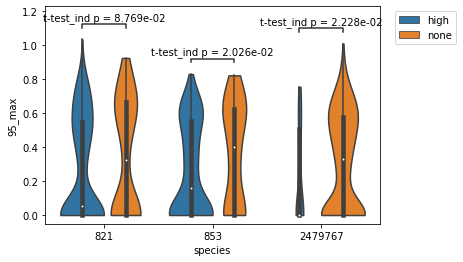

In [192]:
traces=glob.glob("data/Plectoneme/*_gene_plect_*_0.txt")
AA=pd.DataFrame()
BB=pd.DataFrame()
from statannot import add_stat_annotation
for trace in traces:
    type=os.path.basename(trace).split('_')[0]
    if type=='high':
        A=pd.read_csv(trace, delimiter="\t",names=['mean','median','95_max','area','len'])
        # A=A[A['area']!=0]
        A['type']=type
        A['species']=os.path.basename(trace).split('_')[3]
        A['filt']=str(os.path.basename(trace).split('_')[4].split('.')[0])
        AA=AA.append(A)
    else:
        B=pd.read_csv(trace, delimiter="\t",names=['mean','median','95_max','area','len'])
        # B=B[B['area']!=0]
        B['type']=type
        B['species']=os.path.basename(trace).split('_')[3]
        B['filt']=str(os.path.basename(trace).split('_')[4].split('.')[0])
        BB=BB.append(B)
    
C=AA.append(BB)
C=C[C['area']!=0]
C=C[C['len']>=1000]
C['density']=C['area']/C['len']
C['95_max/len']=C['95_max']/C['len']
C.dropna(inplace=True)
C=C.reset_index()
ax=sns.violinplot(data=C,y='95_max',x='species',hue='type',cut=0,scale='count')#,kind="violin",cut=0,scale="count", inner="quartile")

add_stat_annotation(ax, data=C, x='species', y='95_max',hue='type',
                    box_pairs=[(("821", "high"), ("821", "none")),
                                 (("853", "high"), ("853", "none")),
                                 (("2479767", "high"), ("2479767", "none"))
                                ],
                    test='t-test_ind', text_format='full', loc='inside', verbose=2)
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))

In [189]:
C

""


### add in Measurement of bacterial replication rates in microbial communities

## process figures

In [ ]:
traces= glob.glob('data/meta_unfilt/*bedgraph')
ori=pd.read_csv('data/doric10/OriC_db.bed',sep='\t')

for jac in traces:
    zzz=pd.read_csv(jac,sep='\t',names=['tmp','start','end','relAb'])
    tmp=ori[ori['Refseq'].str.contains('NC_'+jac.split('/')[2].split('_')[1])]
    
    plt.figure(figsize=(20, 5))
    try:
        print('running: '+str(tmp['Organism'].item())+" in "+str(os.path.basename(jac).split('_')[2].split('.')[0]))
        ss=np.int(np.round(tmp['start'].item(),-1))
        tt=np.int(np.round(tmp['end'].item(),-1))
        plt.bar(data=zzz[(zzz['start']>ss-250000)&(zzz['end']<tt+250000)],x='start',height='relAb',label='align',color='blue')#][zzz['start']=='1665929']
        plt.bar(data=tmp,x='start',height='OriC AT content',label='OriC start',color='orange')
        plt.bar(data=tmp,x='end',height='OriC AT content',label='OriC end',color='orange')

        plt.axes([.2, .6, .6, .2])
        plt.bar(data=zzz[(zzz['start']>ss-100) &(zzz['end']<tt+100)],x='start',height='relAb',label='align',color='blue')#][zzz['start']=='1665929']
        plt.bar(data=tmp,x='start',height='OriC AT content',label='OriC start',color='orange')
        plt.bar(data=tmp,x='end',height='OriC AT content',label='OriC end',color='orange')

        plt.xlabel("OriC ranges from "+str(tmp['start'].item())+" to "+str(tmp['end'].item())+" for "
            +str(tmp['Organism'].item())+" in "+str(os.path.basename(jac).split('_')[2].split('.')[0])+"max= "+
                   np.max(zzz['relAb'])+" between "+str(np.int(zzz[zzz['relAb']==np.max(zzz['relAb'])][['start']].values))+" and "+str(np.int(zzz[zzz['relAb']==np.max(zzz['relAb'])][['end']].values))+"; median= "+np.median(zzz['relAb']),fontsize=14)
        plt.savefig('img/oric/'+str(os.path.basename(jac).split('.')[0])+'.png',dpi=300,bbox_inches = "tight")

    except TypeError:
        pass
    except ValueError:
        pass

In [ ]:
ori[ori['Organism']=='Staphylococcus_aureus']

In [ ]:
tmp=ori[ori['Refseq'].str.contains('NC_'+jac.split('/')[2].split('_')[1])]

# analyze and score OriC v rest

In [ ]:

def run_vRand(dataset,table,n):
    aa=dataset.loc[dataset.index.isin(np.unique(table['subj']))]
    aa['ecoli']=1
    aa=aa.select_dtypes(include=np.number)
    aa=aa.dropna(how='any',axis=1)

    bb=dataset.loc[~dataset.index.isin(np.unique(table['subj']))]
    bb['ecoli']=0
    bb=bb.select_dtypes(include=np.number)
    bb=bb.dropna(how='any',axis=1)

    for i in aa.columns:
        try:
            cc=stats.kruskal(aa[i].dropna(),bb[i].dropna())
            dd=stats.mannwhitneyu(aa[i].dropna(),bb[i].dropna())
            ee=stats.ttest_ind(aa[i].dropna(),bb[i].dropna())
            # ff=stats.wilcoxon(aa[i].dropna(),bb[i].dropna())
            if ((cc.pvalue<0.005) & (dd.pvalue<0.005)&(ee.pvalue<0.005)):
                print (i,cc.pvalue,dd.pvalue,ee.pvalue)

        except:
            pass

    for i in np.arange(n):
        jeff=np.random.permutation(dataset.index)[0:len(np.unique(table['subj']))]
        aa=dataset.loc[dataset.index.isin(jeff)]
        aa=aa.select_dtypes(include=np.number)
        aa=aa.dropna(how='any',axis=1)

        bb=dataset.loc[~dataset.index.isin(jeff)]
        bb=bb.select_dtypes(include=np.number)
        bb=bb.dropna(how='any',axis=1)
        for i in aa.columns:
            try:
                cc=stats.kruskal(aa[i].dropna(),bb[i].dropna())
                dd=stats.mannwhitneyu(aa[i].dropna(),bb[i].dropna())
                ee=stats.ttest_ind(aa[i].dropna(),bb[i].dropna())
                # ff=stats.wilcoxon(aa[i].dropna(),bb[i].dropna())
                if ((cc.pvalue<0.005) & (dd.pvalue<0.005)&(ee.pvalue<0.005)):
                    print (i,cc.pvalue,dd.pvalue,ee.pvalue)

            except:
                pass

In [ ]:
# ori=pd.read_csv('data/doric10/OriC_db.bed',sep='\t')

cc=pd.DataFrame(ori.Refseq.str.split('.').str[0].tolist())

(cc[cc[0].isin(traces)])

In [ ]:
table=pd.DataFrame()
traces= glob.glob('data/meta*/*bedgraph')
traces=np.sort(traces)
indices = [i for i, s in enumerate(traces) if 'R0295-KKL' in s]
ori=pd.read_csv('data/doric10/OriC_db.bed',sep='\t')
pattable=pd.DataFrame()

# samtools flagstat NC_013008_R0397-LWS_bowtie.sorted.bam
for jac in indices:
    trace=traces[jac]
    zzz=pd.read_csv(trace,sep='\t',names=['tmp','oric_start','oric_end','relAb'])
    tmp=ori[ori['refseq'].str.contains('NC_'+trace.split('/')[2].split('_')[1])]
    # print(str(tmp['Organism']))
    pat=trace.split('_')[2].split('.')[0]
    try:
        zzz['len']=zzz['oric_end']-zzz['oric_start']

        ss=np.int(np.round(tmp['oric_start'].item(),-1))
        tt=np.int(np.round(tmp['oric_end'].item(),-1))

        ccc=np.int(np.round(tmp['oric_start'].item(),0))-1000
        ddd=np.int(np.round(tmp['oric_end'].item(),0))+1000
        www0=zzz[((zzz['oric_start']<ccc)|(zzz['oric_end']>ddd))]
        # www1=zzz[]
        yyy=zzz[(zzz['oric_start']>ccc)&(zzz['oric_end']<ddd)]
        # print([len(zzz),len(www0),len(yyy)])
        # if (np.max(www0.relAb)<np.max(yyy.relAb)):
        # print(str(tmp['Organism'].item()))
        # print([np.max(www0.relAb),np.max(yyy.relAb)])
        plt.figure(figsize=(20,8))
        www0['type']='background'
        yyy['type']='OriC'
        www1=www0.append(yyy)
        # tmpA=plt.hist(www0.relAb,bins=100,log=True)
        # tmpA=plt.hist(www1.relAb,bins=100,log=True)
        # tmpA=plt.hist(yyy.relAb,bins=100,log=True,alpha=0.5)
        sns.histplot(data=www1, x="relAb", hue="type",common_norm=True)#,log_scale=True)#, element="step", fill=False,
    # cumulative=False, common_norm=True)

        # tmpD=(np .max(yyy.relAb))
        tmp['OriC max_relAb']=(np.max(yyy.relAb))
        tmp['background max_relAb']=(np.max(www0.relAb))
        (np.max(www0.relAb))
        plt.xlabel(str(tmp['Organism'].item())+' OriC max_relAb:'+str(tmp['OriC max_relAb'].item())+', background max_relAb:'+str(tmp['background max_relAb'].item()))
        # pattable=pd.concat([pattable,pat],axis=0)
        plt.savefig('img/oric_hist/'+str(os.path.basename(trace).split('.')[0])+'.png',dpi=300,bbox_inches = "tight")

        table=pd.concat([table,tmp],axis=0)
    except ValueError:
        pass
# table['subj']=table['pat'].str.split('-').str[0].tolist()
# table.to_csv('data/oriC_calc_lenWeighted_trim_mean.txt',sep='\t',append=True)

In [ ]:
table=pd.DataFrame()
traces= glob.glob('data/meta_unfilt/*bedgraph')
traces=np.sort(traces)
ori=pd.read_csv('data/doric10/OriC_db.bed',sep='\t')
pattable=pd.DataFrame()
# samtools flagstat NC_013008_R0397-LWS_bowtie.sorted.bam
for jac in traces:
    zzz=pd.read_csv(jac,sep='\t',names=['tmp','start','end','relAb'])
    tmp=ori[ori['Refseq'].str.contains('NC_'+jac.split('/')[2].split('_')[1])]
    # print(str(tmp['Organism']))
    pat=jac.split('_')[2].split('.')[0]
    try:
        zzz['len']=zzz['end']-zzz['start']
        # zzz=zzz[zzz['len']==50]
        # zzz['relAb'].replace(0,1)
        # zzz['score']=zzz['relAb']/zzz['len']
        # zzz['score']=
        ss=np.int(np.round(tmp['start'].item(),-1))
        tt=np.int(np.round(tmp['end'].item(),-1))
        tmpd=zzz[(zzz['start']>ss) &(zzz['end']<tt)]
        tmpdd=zzz[(zzz['start']>ss-250) &(zzz['end']<tt+250)]
        tmpddd=zzz[(zzz['start']>ss-500) &(zzz['end']<tt+500)]

        tmp['mean']=np.sum(zzz['relAb']*zzz['len'])/np.sum(zzz['len'])#np.mean(zzz['score'])
        tmp['ori_mean']=np.sum(tmpd['relAb']*tmpd['len'])/np.sum(tmpd['len'])#np.mean(tmpd['score'])
        tmp['ori_mean_250']=np.sum(tmpdd['relAb']*tmpdd['len'])/np.sum(tmpdd['len'])#np.mean(tmpdd['score'])
        tmp['ori_mean_500']=np.sum(tmpddd['relAb']*tmpddd['len'])/np.sum(tmpddd['len'])#np.mean(tmpddd['score'])
        
        tmp['trim_mean01']=stats.trim_mean(zzz['relAb'],0.01)
        tmp['ori_trim_mean01']=stats.trim_mean(tmpd['relAb'],0.01)
        tmp['ori_trim_mean01_250']=stats.trim_mean(tmpdd['relAb'],0.01)
        tmp['ori_trim_mean01_500']=stats.trim_mean(tmpddd['relAb'],0.01)
        
        tmp['trim_mean1']=stats.trim_mean(zzz['relAb'],0.1)
        tmp['ori_trim_mean1']=stats.trim_mean(tmpd['relAb'],0.1)
        tmp['ori_trim_mean1_250']=stats.trim_mean(tmpdd['relAb'],0.1)
        tmp['ori_trim_mean1_500']=stats.trim_mean(tmpddd['relAb'],0.1)
        
        tmp['trim_mean25']=stats.trim_mean(zzz['relAb'],0.25)
        tmp['ori_trim_mean25']=stats.trim_mean(tmpd['relAb'],0.25)
        tmp['ori_trim_mean25_250']=stats.trim_mean(tmpdd['relAb'],0.25)
        tmp['ori_trim_mean25_500']=stats.trim_mean(tmpddd['relAb'],0.25)
        
        tmp['pat']=pat
        
        
        ccc=np.int(np.round(tmp['start'].item(),0))-50
        ddd=np.int(np.round(tmp['end'].item(),0))+50
        www0=zzz[((zzz['start']<ccc)|(zzz['end']>ddd))]
        # www1=zzz[]
        yyy=zzz[(zzz['start']>ccc)&(zzz['end']<ddd)]
        # print([len(zzz),len(www0),len(yyy)])
        if (np.max(www0.relAb)<np.max(yyy.relAb)):
            # print(str(tmp['Organism'].item()))
            # print([np.max(www0.relAb),np.max(yyy.relAb)])
            plt.figure(figsize=(20,8))
            tmpA=plt.hist(www0.relAb,bins=100,log=True)
            # tmpA=plt.hist(www1.relAb,bins=100,log=True)
            tmpA=plt.hist(yyy.relAb,bins=100,log=True,alpha=0.5)
            # tmpD=(np .max(yyy.relAb))
            tmp['OriC max_relAb']=(np.max(yyy.relAb))
            tmp['background max_relAb']=(np.max(www0.relAb))
            (np.max(www0.relAb))
            plt.xlabel(str(tmp['Organism'].item())+' OriC max_relAb:'+str(tmp['OriC max_relAb'].item())+', background max_relAb:'+str(tmp['background max_relAb'].item()))
            # pattable=pd.concat([pattable,pat],axis=0)
            plt.savefig('img/oric_hist_unfilt/oric_hist_'+str(os.path.basename(jac).split('.')[0])+'.png',dpi=300,bbox_inches = "tight")

            table=pd.concat([table,tmp],axis=0)
    except ValueError:
        pass
table['subj']=table['pat'].str.split('-').str[0].tolist()
table.to_csv('data/oriC_calc_lenWeighted_trim_mean.txt',sep='\t')

In [ ]:
table.to_csv('data/unfilt_oriC_calc_lenWeighted_trim_mean.txt',sep='\t')

In [ ]:
table=pd.read_csv('data/oriC_calc_lenWeighted_trim_mean.txt',sep='\t')

In [ ]:
primary=pd.read_excel('data/Data Raw - Gut Microbiome Cohort Project Database - 300 Cohort v3.0_280921.xlsx',index_col=0,sheet_name='Primary Data')
diet=pd.read_excel('data/Data Raw - Gut Microbiome Cohort Project Database - 300 Cohort v3.0_280921.xlsx',index_col=0,sheet_name='Diet Data')
blood_stool=pd.read_excel('data/Data Raw - Gut Microbiome Cohort Project Database - 300 Cohort v3.0_280921.xlsx',index_col=0,sheet_name='blood and stool biomarkers')
secondary=pd.read_excel('data/Data Raw - Gut Microbiome Cohort Project Database - 300 Cohort v3.0_280921.xlsx',index_col=0,sheet_name='Secondary Data')
MRI=pd.read_excel('data/Data Raw - Gut Microbiome Cohort Project Database - 300 Cohort v3.0_280921.xlsx',index_col=0,sheet_name='MRI scores')

In [ ]:
run_vRand(diet,table,100)

In [ ]:
aa=aa.append(bb)
sns.violinplot(x=aa['ecoli'],y=aa['Niacin_mg'])

In [ ]:
aa['Niacin_mg']

In [ ]:
run_vRand(primary,table,100)

In [ ]:
run_vRand(secondary,table,100)

In [ ]:
run_vRand(blood_stool,table,100)

In [ ]:
run_vRand(MRI,table,100)

In [ ]:
aa=secondary.loc[secondary.index.isin(np.unique(table['subj']))]
aa=aa.select_dtypes(include=np.number)
aa=aa.dropna(how='any',axis=1)

bb=secondary.loc[~secondary.index.isin(np.unique(table['subj']))]
bb=bb.select_dtypes(include=np.number)
bb=bb.dropna(how='any',axis=1)

In [ ]:
tmp=plt.hist(zzz['score'],bins=100,log=True)
tmp=plt.hist(tmpd['score'],bins=100,log=True)
tmp=plt.hist(tmpdd['score'],bins=100,log=True)
tmp=plt.hist(tmpddd['score'],bins=100,log=True)

### compare output

In [ ]:
table.groupby('pat').mean()

In [ ]:
a=plt.hist(table['mean'],bins=100,log=True,alpha=.65)
a=plt.hist(table['ori_mean'],bins=100,log=True,alpha=.5)
a=plt.hist(table['ori_mean_250'],bins=100,log=True,alpha=.35)
a=plt.hist(table['ori_mean_500'],bins=100,log=True,alpha=.25)

In [ ]:
np.sum(table['mean']>table['ori_mean'])/len(table)

In [ ]:
np.sum(table['median']>table['ori_median'])/len(table)

In [ ]:
table.groupby('Organism').median()

In [ ]:
table.groupby('Organism').mean()

In [ ]:
unibact=pd.read_csv('data/328_krakenuniq_raw.csv',index_col=0)
unibact['spec']=(unibact.index).str.split(';').str[0:6].tolist()
jeff=pd.DataFrame(unibact['spec'].tolist(),columns=['tmp','tmp','tmp','tmp','tmp','species'])
jeff=jeff.fillna(method='ffill',axis=1)

In [ ]:
(unibact.index).str.split(';').str[0:6].tolist()[0][5] ## transfered a bunch of these from hku to personal cpos

In [ ]:
jeff[jeff['species'].str.contains('prevot')]#[1:50]
# jeff.ind# tmp=ori[ori['Refseq'].str.contains('NC_'+jac.split('/')[2].split('_')[1])]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))
# N = np.sum(zzz.len)#len(table['mean'])
bottom = 8
max_height = 4

theta = zzz['start']#np.linspace(0.0, 2 * np.pi, N, endpoint=False)
radii = zzz['relAb']#max_height*np.random.rand(N)
width = zzz['len'] #(2*np.pi) / N

ax = plt.subplot(111, polar=True)
bars = ax.bar(x=theta, height=radii, width=width, bottom=bottom)

# Use custom colors and opacity
for r, bar in zip(radii, bars):
    bar.set_facecolor(plt.cm.jet(r / 10.))
    bar.set_alpha(0.8)

plt.show()

In [ ]:
ccc=np.int(np.round(tmp['start'].item(),0))-500
ddd=np.int(np.round(tmp['end'].item(),0))+500
www0=zzz[(zzz['start']<ccc)]
www1=zzz[(zzz['end']>ddd)]
yyy=zzz[(zzz['start']>ccc)&(zzz['end']<ddd)]
[len(zzz),len(www0),len(yyy),len(www1)]
[np.max(www0.relAb),np.max(www1.relAb),np.max(yyy.relAb)]

In [ ]:
np.int(np.round(np.max(yyy.relAb),-3)/100)

In [ ]:
plt.figure(figsize=(20,8))
tmpA=plt.hist(www0.relAb,bins=100,log=True)
tmpA=plt.hist(www1.relAb,bins=100,log=True)
tmpA=plt.hist(yyy.relAb,bins=100,log=True)
# plt.label

In [ ]:
# initialize the figure
plt.figure(figsize=(20,10))
ax = plt.subplot(111, polar=True)
plt.axis('off')

# Draw bars
bars = ax.bar(
    x=angles, 
    height=heights, 
    width=width, 
    bottom=lowerLimit,
    linewidth=2, 
    edgecolor="white",
    color="#61a4b2",
)

# little space between the bar and the label
labelPadding = 4

# Add labels
for bar, angle, height, label in zip(bars,angles, heights, df["Name"]):

    # Labels are rotated. Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle)

    # Flip some labels upside down
    alignment = ""
    if angle >= np.pi/2 and angle < 3*np.pi/2:
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"

    # Finally add the labels
    ax.text(
        x=angle, 
        y=lowerLimit + bar.get_height() + labelPadding, 
        s=label, 
        ha=alignment, 
        va='center', 
        rotation=rotation, 
        rotation_mode="anchor") 

In [ ]:
# ori['len']=ori['end']-ori['start']
np.sort(ori['len'])ATACxGEX=pd.read_csv('/content/drive/My

In [ ]:
ATACxGEX=pd.read_csv('data/neurIPS2021/ATACxGEX_O.bed',sep='\t',names=['chr','start','end','id','gene','chr2','start2','end2','hits'])
GEXxATAC=pd.read_csv('data/neurIPS2021/GEXxATAC_O.bed',sep='\t',names=['chr','start','end','id','gene','chr2','start2','end2','hits'])

In [ ]:
plt.figure(figsize=(20, 5))
dd=GEXxATAC[GEXxATAC['chr']=='chr1']
plt.bar(data=dd,x=np.log(dd['start']),height='hits')

In [ ]:
import duolingo
lingo  = duolingo.Duolingo('dcolinmorgan', 'M6742632')

In [ ]:
# lingo  = duolingo.Duolingo('kartik', '...')
ww=(lingo.get_known_words('sv'))
vv=lingo.get_translations(ww, source='sv', target='en')

In [ ]:
# with open('dcm_duolingo.csv', 'w') as f:  # You will need 'wb' mode in Python 2.x
#     w = csv.DictWriter(f, vv.keys())
#     w.writeheader()
#     w.writerow(vv)

import json
# with open('dcm_duolingo.txt', 'w') as file:
#      file.write(json.dumps(vv))
        
with open('dcm_duolingo.txt', 'w', encoding='utf-8') as f:
    json.dump(vv, f, ensure_ascii=False, indent=4)

In [ ]:
# pp=(lingo.get_vocabulary(language_abbr='sv'))
pd.DataFrame((pp))

In [ ]:

pp.keys()

In [ ]:
pp.vocab_overview

# replot TSS

In [ ]:
pd.read_csv('/groups/cgsd/gordonq/TSS_depth/nanopore_data/')

# troubleshoot

In [ ]:
bact_stat=pd.read_csv('flagstatA.txt',sep='\t',names=['q0','q1','type'])
bact_stat['sample']=bact_stat[bact_stat['q0'].str.contains(".bam")]['q0'].repeat(21).values
# bact_stat.loc[1:1000]
bact_stat['bact']=bact_stat['sample'].str.split('_').str[1].tolist()
bact_stat['pat']=bact_stat['sample'].str.split('_').str[2].tolist()
del bact_stat['sample'], bact_stat['q1']
bact_stat.dropna(how='any',inplace=True)
bact_stat=bact_stat[~bact_stat.type.str.contains("%")]

In [ ]:
bact_stat['q0']=bact_stat.q0.astype('int')
bact_stat['q1']=np.log10(bact_stat['q0'])

In [ ]:
sns.set_theme(style="whitegrid")
# iris = sns.load_dataset("iris")
plt.figure(figsize=(12, 24))
# "Melt" the dataset to "long-form" or "tidy" representation
# iris = pd.melt(bact_stat, ["bact",'patient'], var_name="type")
# del bact_stat['sample'], bact_stat['q1']
# bact_stat.dropna(how='any',inplace=True)
# bact_stat=bact_stat[~bact_stat.type.str.contains("%")]
# Initialize the figure
# f, ax = plt.subplots()
# sns.despine(bottom=True, left=True)

# Show each observation with a scatterplot
ax=sns.stripplot(x="q1", y="type", hue="bact",
              data=bact_stat, dodge=True, alpha=.25, zorder=1)

# Show the conditional means, aligning each pointplot in the
# center of the strips by adjusting the width allotted to each
# category (.8 by default) by the number of hue levels
ax=sns.pointplot(x="q1", y="type", hue="bact",
              data=bact_stat, dodge=.8 - .8 / 3,
              join=False, palette="dark",
              markers="d", scale=.75, ci=None)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1),ncol=2)
plt.savefig("flagstat.png",dpi=300,bbox_inches = "tight")

# Improve the legend
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles, labels, title="bact",
#           handletextpad=0, columnspacing=1,
#           loc='lower center', ncol=5, frameon=False)#,bbox_to_anchor=(1.05, 1),borderaxespad=0.)


In [ ]:
jeff=pd.pivot_table(bact_stat,columns='type',index=['bact','pat'],values='q0')

In [ ]:
jeff=jeff.reset_index()

In [ ]:
jeff =jeff.loc[:, (jeff != 0).any(axis=0)]
# del jeff['secondary']  
del jeff['primary mapped'], jeff['with itself and mate mapped']

In [ ]:
jeff

In [ ]:
sns.pairplot(jeff, hue="bact")
plt.savefig("flagstat_corr.png",dpi=300,bbox_inches = "tight")


In [ ]:
jeff0=pd.melt(jeff,id_vars=['bact','pat'])

In [ ]:
jeff0['log10_value']=np.log10(jeff0.value)

In [ ]:
sns.set_theme(style="whitegrid")
# iris = sns.load_dataset("iris")
plt.figure(figsize=(12, 24))
# "Melt" the dataset to "long-form" or "tidy" representation
# iris = pd.melt(bact_stat, ["bact",'patient'], var_name="type")
# del bact_stat['sample'], bact_stat['q1']
# bact_stat.dropna(how='any',inplace=True)
# bact_stat=bact_stat[~bact_stat.type.str.contains("%")]
# Initialize the figure
# f, ax = plt.subplots()
# sns.despine(bottom=True, left=True)

# Show each observation with a scatterplot
ax=sns.stripplot(x="log10_value", y="type", hue="bact",
              data=jeff0, dodge=True, alpha=.25, zorder=1)

# Show the conditional means, aligning each pointplot in the
# center of the strips by adjusting the width allotted to each
# category (.8 by default) by the number of hue levels
ax=sns.pointplot(x="log10_value", y="type", hue="bact",
              data=jeff0, dodge=.8 - .8 / 3,
              join=False, palette="dark",
              markers="d", scale=.75, ci=None)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1),ncol=2)
plt.savefig("flagstat_red.png",dpi=300,bbox_inches = "tight")

# Improve the legend
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles, labels, title="bact",
#           handletextpad=0, columnspacing=1,
#           loc='lower center', ncol=5, frameon=False)#,bbox_to_anchor=(1.05, 1),borderaxespad=0.)
